In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

/Users/tural/.virtualenvs/P3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Список литературы

1. "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", Géron, A., 2017, *O'Reilly Media*
2. "An Introduction to Statistical Learning: With Applications in R.", Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2014, *Springer Publishing Company, Incorporated*
3. [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
4. "Scaling to Very Very Large Corpora for Natural Language Disambiguation", Michele Banko and Eric Brill, 2001, *Microsoft Research*

# Потенциальные проблемы

1. Нелинейный данные
2. Корреляция ошибок
    * Например, в случае с временной последовательностью, ошибка может зависеть от времени.
3. Неконстантное отклонение ошибки
    * Ошибка может иметь форму воронки: вначале ошибки маленькие - затем увеличиваются.
4. Выбросы (outliers)
5. Точки с высоким коэффициентом усиления (high-leverage points)
6. Коллинеарность
    * Когда два предсказателя сильно коррелируют друг с другом.

## Outliers

In [2]:
good_X = 2 * np.random.rand(100, 1)
good_y = 4 + 3 * good_X + np.random.randn(100, 1)
outliers_X = np.array([1.4, 1.5, 1.6]).reshape(-1, 1)
outliers_y = np.array([18, 18, 19]).reshape(-1, 1)
X, y = np.r_[good_X, outliers_X], np.r_[good_y, outliers_y]

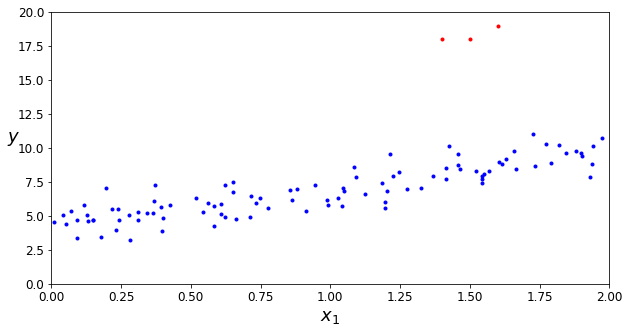

In [3]:
plt.plot(good_X, good_y, "b.")
plt.plot(outliers_X, outliers_y, "r.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 20])
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression().fit(X, y)
lm2 = LinearRegression().fit(good_X, good_y)

/Users/tural/.virtualenvs/P3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [5]:
xs = np.array([0, 2]).reshape(-1, 1)
ys1 = lm1.predict(xs)
ys2 = lm2.predict(xs)

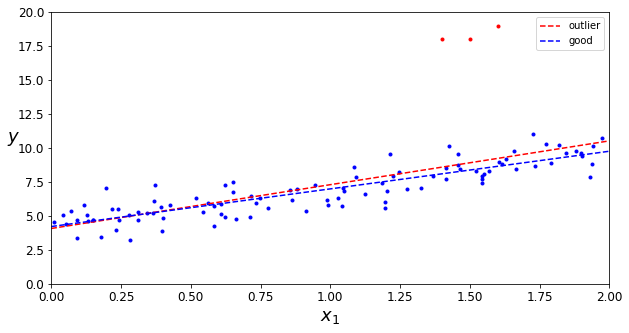

In [6]:
plt.plot(good_X, good_y, "b.")
plt.plot(outliers_X, outliers_y, "r.")

plt.plot(xs, ys1, "r--", label="outlier")
plt.plot(xs, ys2, "b--", label="good")

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 20])
plt.legend()

#### Подробнее про все это можно почитать в [2], глава 3.

# Альтернативные способы обучения

Стандартное обучение исходной модели (например, метод наименьших квадратов в линейной регрессии) может создавать описанные выше проблемы. Чтобы уменьшить вероятность их возникновения, применяют альтернативные способы обучения, такие как:
* обучение с выбором подмножества фич (subset selection)
* обучение с регуляризаций (shrinkage или regularization)
* обучение с уменьшением размерности фич (dimensionality reduction)

## Subset selection

Идея проста:
* создать множество моделей-кандидатов, содержащих только часть фич
* выбрать лучшего кандидата, оценив тестовую ошибку

### Best subset selection

```python
candidates = [M0]
for k in range(1, p + 1):
    pre_candidates = get_fit_models(n_features=k)  # все комбинации из p по k
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

### Stepwise selection

Best subset selection очень дорог, хотя и гарантирует нахождение оптимального решения. Более того, чем больше $p$, тем больше вероятность найти модели, которые показывают отличные результаты на тренировочных данных и плохие на тестовых. Поэтому мы хотим сузить область поиска кандидатов.

#### Forward stepwise selection

```python
candidates = [M0]
for k in range(0, p):
    # находим модели, дополняющие предыдущую модель одной фичей
    pre_candidates = get_models_with_one_additional_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

#### Backward stepwise selection

```python
candidates = [Mp]
for k in range(p, 0, -1):
    # находим модели без одной из фич, присутствующих в candidates[-1]
    pre_candidates = get_models_without_one_feature(candidates[-1])
    Mk = select_best_on_training(pre_candidates)
    candidates.append(Mk)
```

Forward можно использовать, когда p > n, а backward - нет. Недостаток обеих моделей - их жадность:).

#### Hybrid approaches

Возможно и добавление, и удаление фич.

### Выбор лучшего кандидата

* косвенная оценка: оцениваем модели на тренировочных данных, корректируя тренировочную ошибку ($C_p$, $AIC$, $BIC$, скорректированный $R^2$)
* непосредственная оценка: оцениваем модели на validation set
    
Косвенную оценку используют, когда очень дорого делать cross-validation. 

Важно помнить, что $RSS$ и $R^2$ улучшаются каждый раз, когда мы добавляем еще один предсказатель. Поэтому использовать данные метрики для выбора лучшего кандидата при косвенной оценке нельзя (почему? а можно при непосредственной?). 

$$
C_p = \frac{1}{n}(RSS + 2d{\hat{\sigma}}^2) \\
AIC = \frac{1}{n{\hat{\sigma}}^2}(RSS + 2d{\hat{\sigma}}^2) \\
BIC = \frac{1}{n}(RSS + log(n)d{\hat{\sigma}}^2) \\
Adjusted\ R^2 = 1 - \frac{\frac{RSS}{n - d - 1}}{\frac{TSS}{n-1}} \\
d \text{ - количество предсказателей}
$$

## Shrinkage (регуляризация)

#### Линейная регрессия
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2$$
#### Ridge
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p \beta_j^2$$
#### Lasso
$$RSS = \sum_{i=1}^n (y_i - \beta_0 - \sum_{j=1}^p \beta_j * x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_j|$$

In [7]:
# download_file("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv")
adv_df = pd.read_csv('/Users/tural/PyNotes/Netology, feature engineering/data/Advertising.csv', usecols=[1,2,3,4])
adv_df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [8]:
from sklearn.linear_model import Ridge, Lasso

In [9]:
X = adv_df[["TV", "Radio", "Newspaper"]].as_matrix()
y = adv_df.Sales

In [10]:
lm = LinearRegression().fit(X, y)
print(lm.intercept_)
print(lm.coef_)

2.93888936946
[ 0.04576465  0.18853002 -0.00103749]


In [11]:
rg = Ridge().fit(X, y)
print(rg.intercept_)
print(rg.coef_)

2.93896745833
[ 0.04576464  0.1885251  -0.00103629]


In [12]:
rg = Lasso().fit(X, y)
print(rg.intercept_)
print(rg.coef_)

3.04021558348
[ 0.04566142  0.1834644   0.        ]


## Dimensionality reduction

Трансформирует $p$ фич в $M$ линейных комбинаций этих фич, так, что $M < p$. Новые фичи ($Z_i$) используются для построения модели. Основная идея при трансформации - объяснить новыми фичами как можно больший процент вариативности (variance) исходных данных, при этом уменьшив размерность пространства.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1]).fit(X)
for i in range(1, X.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.914
n-components=2, explained variance 0.978
n-components=3, explained variance 1.000


In [14]:
new_adv_df = pd.DataFrame(PCA(n_components=1).fit_transform(X), columns=["f1"])
new_adv_df["Sales"] = adv_df.Sales
new_adv_df.head(5)

,f1,Sales
0,83.788546,22.1
1,-102.138730,10.4
2,-128.992484,9.3
3,5.070972,18.5
4,34.059003,12.9


In [15]:
pca_lm = smf.ols('Sales ~ f1', new_adv_df).fit()
rss = np.sum(pca_lm.resid ** 2)
print("RSS:", rss)
print("R^2:", pca_lm.rsquared)

RSS: 2088.6304923
R^2: 0.614440993096


#### Подробнее про все это можно почитать в [2], глава 6.

# SVM

Support Vector Machine (SVM), он же метод опорных векторов, одна из самых мощных и гибких ML моделей. SVM поддерживает линейную и нелинейную классификацию, регрессию и даже поиск выбросов. Лучше всего SVM подходит для классификации сложных датасетов среднего или малого размера.

## Теория

В случае с двухмерными линейно разделяемыми данными, SVM создает границу принятия решения так, чтобы экземпляры двух классов были максимально удалены от этой границы. 

In [16]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[0, 5.5, 0, 2]

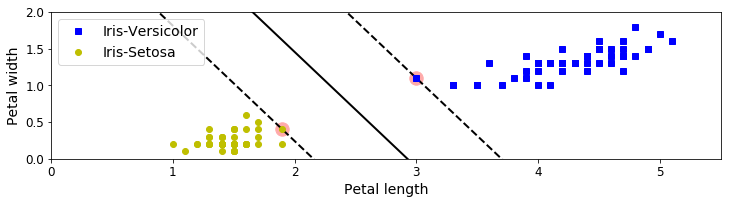

In [17]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

Можно думать об SVM как о классификаторе, который пытается построить наиболее широкую *улицу* между данными. Точки, находящиеся на границе улицы, называются опорными векторами (support vector). 

SVM чувствителен к масштабированию данных:

[-2, 2, -2, 2]

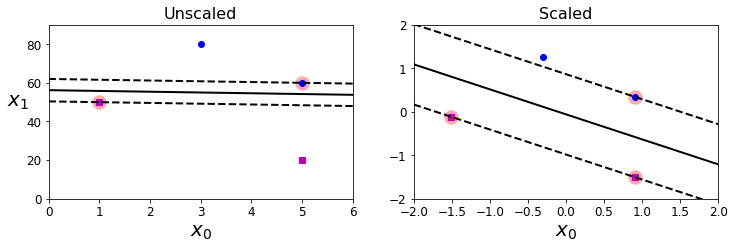

In [18]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

## Hard & soft margin classification

Рассмотренные до этого примеры - это hard margin classification. При hard margin классификации экземпляры одного класса находятся по одну сторону от разделяющей поверхности. Если в данных есть выбросы, hard margin classification не всегда находит оптимальную границу разделения (а иногда совсем ее не находит).

[0, 5.5, 0, 2]

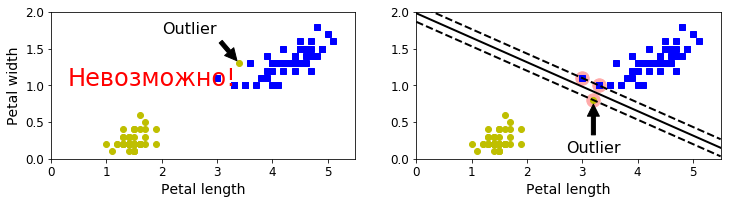

In [19]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Невозможно!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

В таких случаях используется soft margin classification. Данный способ классификации допускает нарушение границы разделения некоторым количеством экземпляров. В sklearn допустимое нарушение регулируется параметром $C$.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
])
scaled_svm_clf2 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf2),
])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [21]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 6, 0.8, 2.8]

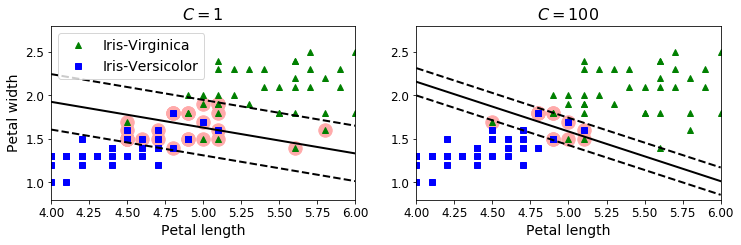

In [22]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

Математика под капотом:
$$\hat{y} = 
\begin{cases}
    0\ if\ \mathbf{w}^T \cdot \mathbf{x} + b < 0,\\
    1\ if\ \mathbf{w}^T \cdot \mathbf{x} + b \ge 0\\
\end{cases}
$$

Цель - найти оптимальный $\mathbf{w}$ и $b$.

## Нелинейная классификация

В некоторых случаях данные не могут быть разделены линейно:

[-4.5, 4.5, -0.2, 0.2]

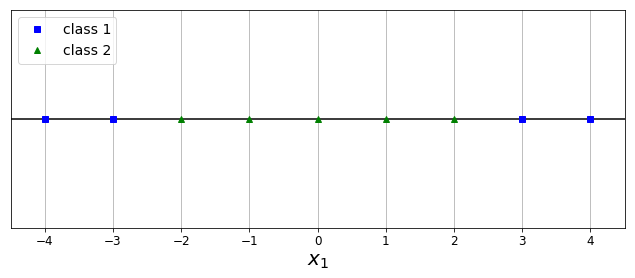

In [23]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs", label="class 1")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^", label="class 2")
plt.legend(loc="upper left", fontsize=14)
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

Но, например, если мы добавим еще одну фичу $x_2 = {x_1}^2$, то данные станут линейно разделимыми:

[-4.5, 4.5, -1, 17]

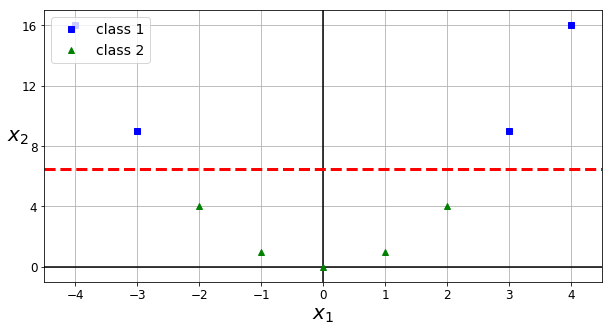

In [24]:
X2D = np.c_[X1D, X1D**2]

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs", label="class 1")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^", label="class 2")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

Еще один пример линейно неразделимых данных:

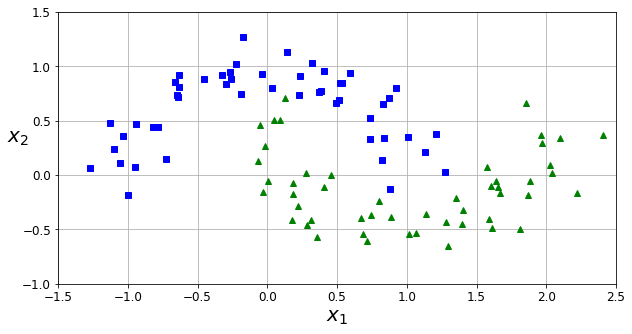

In [25]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
new_X = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3))
]).fit_transform(X)

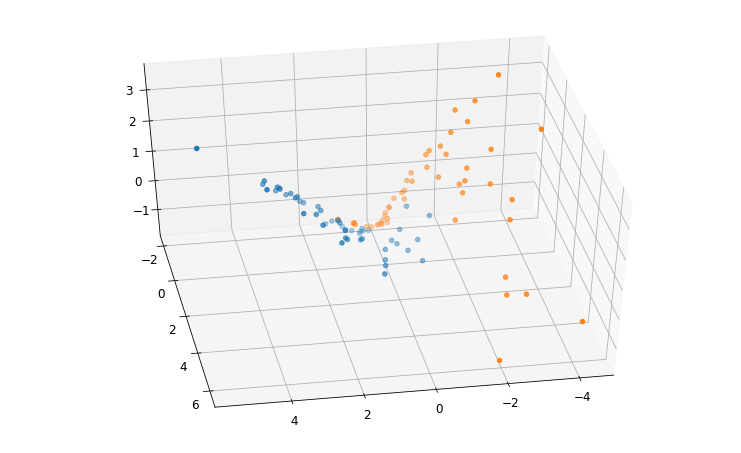

In [27]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig, azim=80, elev=45)
ax.scatter3D(new_X[:, 0][y==0], new_X[:, 1][y==0], new_X[:, 2][y==0], "bs")
ax.scatter3D(new_X[:, 0][y==1], new_X[:, 1][y==1], new_X[:, 2][y==1], "g^")

Как и раньше, данную задачу классификации можно решить созданием полиномиальных фич:

In [28]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

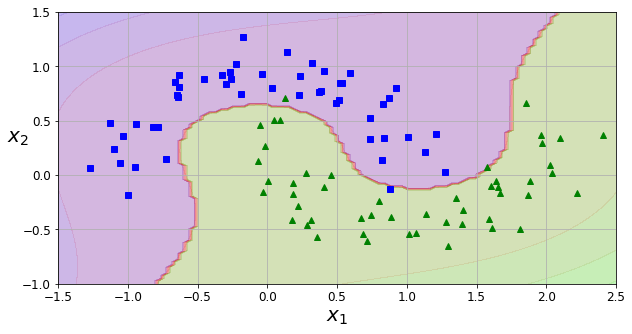

In [29]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Но проблема в том, что `PolynomialFeatures(degree=3)` увеличивает количество фич и, как следствие, объем занимаемой памяти.

In [30]:
print(X.shape)
print(PolynomialFeatures(degree=3).fit_transform(X).shape)

(100, 2)
(100, 10)


Чтобы избежать увеличения объема памяти, используют kernalization (ядерное преобразование).

## Kernel trick

Предположим, мы хотим применить к данным полиномиальное преобразование второй степени, после чего воспользоваться SVM классификатором. Функция отображения в полином второй степени выглядит так:
$$\phi(\mathbf{x}) = \phi(\left(\begin{array}{c}x_1\\x_2\end{array}\right)) = \left(\begin{array}{c}{x_1}^2\\\sqrt{2}x_1x_2\\{x_2}^2\end{array}\right)$$

Давайте теперь посмотрим, что произойдет с двухмерными векторами $\mathbf{a}$ и $\mathbf{b}$, если мы применим к ним функцию отображения, а затем найдем dot-product преобразованных векторов.
$$\phi(\mathbf{a})^T \cdot \phi(\mathbf{b}) = \left(\begin{array}{c}{a_1}^2\\\sqrt{2}a_1a_2\\{a_2}^2\end{array}\right)^T \cdot \left(\begin{array}{c}{b_1}^2\\\sqrt{2}b_1b_2\\{b_2}^2\end{array}\right) = {a_1}^2 {b_1}^2 + 2a_1b_1a_2b_2 + {a_2}^2 {b_2}^2 = (a_1b_1 + a_2b_2)^2 = (\left(\begin{array}{c}a_1\\a_2\end{array}\right)^T \cdot \left(\begin{array}{c}b_1\\b_2\end{array}\right))^2 = (\mathbf{a}^T \cdot \mathbf{b})^2$$

Т.е. $\phi(\mathbf{a})^T \cdot \phi(\mathbf{b}) = (\mathbf{a}^T \cdot \mathbf{b})^2$ и не нужно создавать никаких дополнитильных фич.

Поиск решения в SVM - это constrained optimization problem, которую в некоторых случаях (SVM как раз тот случай) можно решить через двойственную задачу. В случае с SVM она выглядит так:
$$\operatorname*{minimize}_\alpha \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)}\alpha^{(j)} t^{(i)}t^{(j)} \mathbf{x}^{(i)^T}\mathbf{x}^{(j)} - \sum_{i=1}^m \alpha^{(i)}$$
где
$$\alpha^{(i)} \ge 0\ для\ i=1, 2, \dots, m$$

Найдя $\hat{\alpha}$, мы можем выразить через него $\mathbf{w}$ и $b$:
$$
\hat{\mathbf{w}} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
\hat{b} = \frac{1}{n_S} \sum_{i=1}^m (1 - t^{(i)} (\hat{\mathbf{w}}^T \mathbf{x}^{(i)})) \\
\hat{\alpha}^{(i)} > 0
$$

Теперь, чтобы предсказать класс для экземпляра $\mathbf{x}^{(n)}$, достаточно воспользоваться полученными равенствами и kernel trick-ом:

$$
h_{\hat{\mathbf{w}}, \hat{b}}(\phi(\mathbf{x}^{(n)})) = \\
\hat{\mathbf{w}}^T \cdot \phi(\mathbf{x}^{(n)}) + \hat{b} = \\ (\sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \phi(\mathbf{x}^{(i)}))^T \cdot \phi(\mathbf{x}^{(n)}) + \hat{b} = \\  \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} (\phi(\mathbf{x}^{(i)})^T \cdot \phi(\mathbf{x}^{(n)})) + \hat{b} = \\ \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}) + \hat{b}
$$

где $K(\mathbf{a}, \mathbf{b})$ - ядерная функция.

## Существующие ядра

* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = exp(-\gamma\|\mathbf{a} - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

## Пример

In [31]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Text(0.5,1,'$d=10, r=100, C=5$')

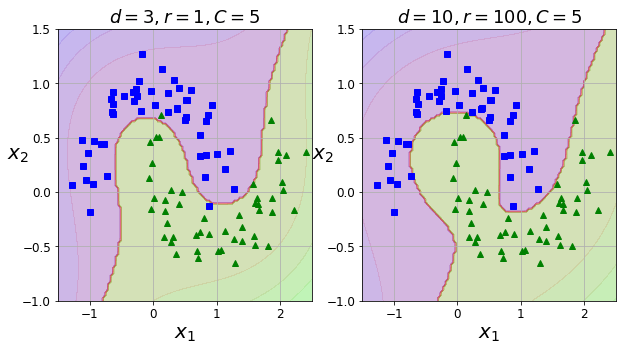

In [32]:
plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

#### Подробнее в [1], глава 5